In [1]:
# imports
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
# local
import wrangle as w

In [2]:
df = w.wrangle_logs()
# Replace missing values with 0 in column: 'program_id'
df = df.fillna({'program_id': 0})
# Filter rows based on column: 'path'
df = df[df['path'] != "/"]
# Filter rows based on column: 'path'
df = df[df['path'] != "toc"]
# Filter rows based on column: 'path'
df = df[df['path'] != "search/search_index.json"]
df_backup = df

In [3]:
df = df_backup
df

,path,user_id,cohort_id,ip,name,start_date,end_date,program_id
datetime,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
2021-04-21 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
2021-04-21 16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 812093 entries, 2018-01-26 09:56:02 to 2021-04-21 16:44:39
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   path        812093 non-null  object        
 1   user_id     812093 non-null  int64         
 2   cohort_id   812093 non-null  float64       
 3   ip          812093 non-null  object        
 4   name        812093 non-null  object        
 5   start_date  766350 non-null  datetime64[ns]
 6   end_date    766350 non-null  datetime64[ns]
 7   program_id  812093 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 55.8+ MB


In [5]:
df.reset_index().describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
datetime,812093,2019-12-06 05:37:18.780022016,2018-01-26 09:56:02,2019-03-15 09:46:50,2020-02-03 13:51:27,2020-09-17 14:53:04,2021-04-21 16:44:39,NaN
user_id,812093.0,456.56212,1.0,267.0,471.0,658.0,981.0,249.829355
cohort_id,812093.0,45.605551,0.0,26.0,33.0,57.0,139.0,33.807564
start_date,766350,2018-12-21 00:01:49.247211008,2014-02-04 00:00:00,2018-05-29 00:00:00,2019-07-15 00:00:00,2020-03-23 00:00:00,2021-04-12 00:00:00,NaN
end_date,766350,2019-05-08 08:40:15.614797312,2014-02-04 00:00:00,2018-10-11 00:00:00,2019-12-11 00:00:00,2020-08-20 00:00:00,2021-10-01 00:00:00,NaN
program_id,812093.0,1.966463,0.0,2.0,2.0,2.0,4.0,0.611341


1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?


In [6]:
df2 = df.reset_index()
df2

,datetime,path,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
4,2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...
812088,2021-04-21 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
812089,2021-04-21 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
812090,2021-04-21 16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
812091,2021-04-21 16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86,Staff,2014-02-04,2014-02-04,2.0


In [7]:
# Performed 1 aggregation grouped on columns: 'program_id', 'path'
pg_path = df2.groupby(['program_id', 'path']).agg(path_count=('path', 'count')).reset_index()
# Sort by column: 'path_count' (descending)
pg_path = pg_path.sort_values(['path_count'], ascending=[False])
pg_path

,program_id,path,path_count
3303,2.0,javascript-i,17457
3277,2.0,java-iii,12683
3191,2.0,html-css,12569
3265,2.0,java-ii,11719
3588,2.0,spring,11376
...,...,...,...
3558,2.0,slides/array-lists,1
816,0.0,elements,1
834,0.0,examples/postwork/data_extraction.zip,1
3555,2.0,sgithubtudents/1215,1


In [8]:
# Filter rows based on column: 'program_id'
pg_path = pg_path[pg_path['program_id'] == 1]
pg_path

,program_id,path,path_count
1614,1.0,index.html,1011
1652,1.0,javascript-i,736
1591,1.0,html-css,542
1783,1.0,spring,501
1641,1.0,java-iii,479
...,...,...,...
1729,1.0,pre-work,1
1683,1.0,javascript-with-html,1
1682,1.0,javascript-ii/promisesdfghjkjhgfs,1
1651,1.0,javascript-functions,1


In [9]:
# program 1: javascript-i/introduction/working-with-data-types-operators-and-variables
# program 2: javascript-i/introduction/working-with-data-types-operators-and-variables
# program 3: classification/overview
# program 4: content/html-css/introduction.html

2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?


In [10]:
df2

,datetime,path,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
4,2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...
812088,2021-04-21 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
812089,2021-04-21 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
812090,2021-04-21 16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
812091,2021-04-21 16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86,Staff,2014-02-04,2014-02-04,2.0


In [11]:
# Performed 1 aggregation grouped on columns: 'program_id', 'name', 'path'
glossy = df2.groupby(['program_id', 'name', 'path']).agg(path_count=('path', 'count')).reset_index()
# Sort by column: 'path_count' (descending)
glossy = glossy.sort_values(['path_count'], ascending=[False])
# Filter rows based on column: 'name'
glossy = glossy[glossy['name'] != "Staff"]
# Filter rows based on column: 'program_id'
# glossy = glossy[glossy['program_id'] != 3]
glossy

,program_id,name,path,path_count
13955,3.0,Darden,classification/overview,1109
5071,2.0,Ceres,javascript-i,1003
13960,3.0,Darden,classification/scale_features_or_not.svg,943
6700,2.0,Jupiter,javascript-i,926
6411,2.0,Hyperion,javascript-i,910
...,...,...,...,...
8189,2.0,Pinnacles,content/php_i/intro-via-interactive-shell/hell...,1
8188,2.0,Pinnacles,content/php_i/intro-via-interactive-shell/gitb...,1
8187,2.0,Pinnacles,content/php_i/intro-via-interactive-shell/exit...,1
8186,2.0,Pinnacles,content/php_i/intro-via-interactive-shell/doin...,1


In [12]:
# Filter rows based on column: 'path'
glossy = glossy[glossy['path'] == "classification/overview"]
glossy

,program_id,name,path,path_count
13955,3.0,Darden,classification/overview,1109
14231,3.0,Easley,classification/overview,445
13577,3.0,Curie,classification/overview,136
14424,3.0,Florence,classification/overview,60
13128,3.0,Bayes,classification/overview,35
687,0.0,unknown,classification/overview,4
10290,2.0,Teddy,classification/overview,1


In [13]:
# darden seemed to refer to classification/overview almost twice
# as many times as the other cohorts combined

3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?


In [14]:
df2

,datetime,path,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
4,2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...
812088,2021-04-21 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
812089,2021-04-21 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
812090,2021-04-21 16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0
812091,2021-04-21 16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86,Staff,2014-02-04,2014-02-04,2.0


In [15]:
active = (df2['datetime'] >= df2['start_date']) & (df2['datetime'] <= df2['end_date'])
active

0         False
1         False
2         False
3          True
4          True
          ...  
812088    False
812089    False
812090    False
812091    False
812092    False
Length: 812093, dtype: bool

In [16]:
df2 = df2.assign(active=active)
df2

,datetime,path,user_id,cohort_id,ip,name,start_date,end_date,program_id,active
0,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,True
4,2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,True
...,...,...,...,...,...,...,...,...,...,...
812088,2021-04-21 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0,False
812089,2021-04-21 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0,False
812090,2021-04-21 16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0,False
812091,2021-04-21 16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86,Staff,2014-02-04,2014-02-04,2.0,False


In [17]:
def get_lower_and_upper_bounds(s, k=1.5):
    '''
    Given a series and a cutoff value, k, returns the lower and upper outliers for the
    series.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper = q3 + k * iqr
    lower = q1 - k * iqr
    return lower,upper

In [18]:
# Performed 4 aggregations grouped on columns: 'user_id', 'program_id', 'name'
lazy_users = df2[df2.active==True].groupby(['user_id', 'program_id', 'start_date', 'end_date', 'name']).agg(path_count=('path', 'count'), datetime_first=('datetime', 'first'), datetime_last=('datetime', 'last'), ip_mode=('ip', lambda s: s.value_counts().index[0])).reset_index()
lazy_users

,user_id,program_id,start_date,end_date,name,path_count,datetime_first,datetime_last,ip_mode
0,2,2.0,2018-01-08,2018-05-17,Teddy,1473,2018-01-26 09:56:24,2018-05-10 18:25:38,97.105.19.61
1,3,2.0,2018-01-08,2018-05-17,Teddy,1457,2018-01-26 09:56:46,2018-05-14 15:17:24,97.105.19.61
2,4,2.0,2018-01-08,2018-05-17,Teddy,638,2018-01-26 09:58:26,2018-03-27 14:28:18,97.105.19.61
3,5,2.0,2018-01-08,2018-05-17,Teddy,1538,2018-01-26 09:59:22,2018-05-11 01:07:17,97.105.19.61
4,6,2.0,2018-01-08,2018-05-17,Teddy,1213,2018-01-26 10:00:02,2018-05-11 09:55:00,97.105.19.61
...,...,...,...,...,...,...,...,...,...
729,976,2.0,2021-04-12,2021-10-01,Oberon,26,2021-04-12 16:47:03,2021-04-21 09:31:21,72.26.31.59
730,977,2.0,2021-04-12,2021-10-01,Oberon,84,2021-04-12 21:05:35,2021-04-21 09:46:37,104.190.247.231
731,978,2.0,2021-04-12,2021-10-01,Oberon,35,2021-04-12 16:47:06,2021-04-21 10:21:13,73.85.64.161
732,979,2.0,2021-04-12,2021-10-01,Oberon,115,2021-04-12 21:10:41,2021-04-21 10:53:46,107.77.218.33


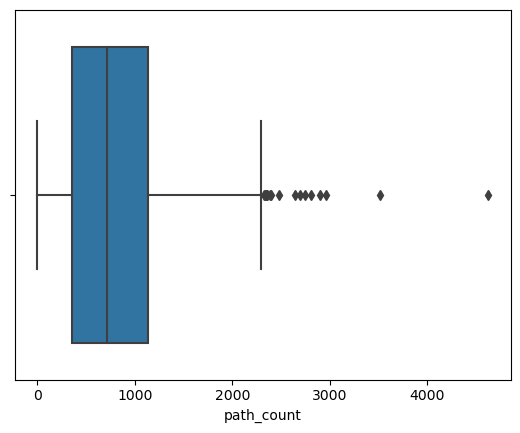

In [19]:
sns.boxplot(data=lazy_users,x='path_count')
plt.show()

In [20]:
lazy_users.path_count.quantile([.25])

0.25    353.5
Name: path_count, dtype: float64

In [21]:
# Derive column 'duration' from columns: 'start_date', 'end_date'
lazy_users.insert(4, 'duration', lazy_users.apply(lambda row : (row['end_date']-row['start_date']).days, axis=1))
# Derive column 'days_active' from columns: 'datetime_first', 'datetime_last'
lazy_users.insert(9, 'days_active', lazy_users.apply(lambda row : (row['datetime_last']-row['datetime_first']).days, axis=1))
# Filter rows based on column: 'path_count'
lazy_users = lazy_users[lazy_users['path_count'] < lazy_users['duration']]
lazy_users

,user_id,program_id,start_date,end_date,duration,name,path_count,datetime_first,datetime_last,days_active,ip_mode
10,13,2.0,2018-01-08,2018-05-17,129,Teddy,78,2018-01-26 10:33:25,2018-05-02 17:15:29,96,97.105.19.61
14,17,2.0,2017-09-27,2018-02-15,141,Sequoia,134,2018-01-26 10:35:35,2018-02-13 12:57:15,18,97.105.19.61
18,22,2.0,2017-09-27,2018-02-15,141,Sequoia,110,2018-01-26 11:11:52,2018-02-10 14:13:18,15,97.105.19.61
20,24,2.0,2017-09-27,2018-02-15,141,Sequoia,24,2018-01-26 11:24:17,2018-02-07 11:07:31,11,97.105.19.61
23,27,2.0,2017-09-27,2018-02-15,141,Sequoia,134,2018-01-26 11:40:35,2018-02-13 10:55:32,17,97.105.19.61
...,...,...,...,...,...,...,...,...,...,...,...
729,976,2.0,2021-04-12,2021-10-01,172,Oberon,26,2021-04-12 16:47:03,2021-04-21 09:31:21,8,72.26.31.59
730,977,2.0,2021-04-12,2021-10-01,172,Oberon,84,2021-04-12 21:05:35,2021-04-21 09:46:37,8,104.190.247.231
731,978,2.0,2021-04-12,2021-10-01,172,Oberon,35,2021-04-12 16:47:06,2021-04-21 10:21:13,8,73.85.64.161
732,979,2.0,2021-04-12,2021-10-01,172,Oberon,115,2021-04-12 21:10:41,2021-04-21 10:53:46,8,107.77.218.33


In [22]:
lazy_users.program_id.value_counts()

2.0    102
3.0      5
Name: program_id, dtype: int64

In [23]:
lazy_users.name.value_counts()

Oberon       26
Neptune      21
Sequoia      16
Jupiter       6
Voyageurs     5
Europa        3
Andromeda     3
Darden        3
Luna          3
Bash          2
Hyperion      2
Teddy         2
Fortuna       2
Ceres         2
Zion          2
Yosemite      2
Bayes         1
Ganymede      1
Easley        1
Kalypso       1
Marco         1
Ulysses       1
Apex          1
Name: name, dtype: int64

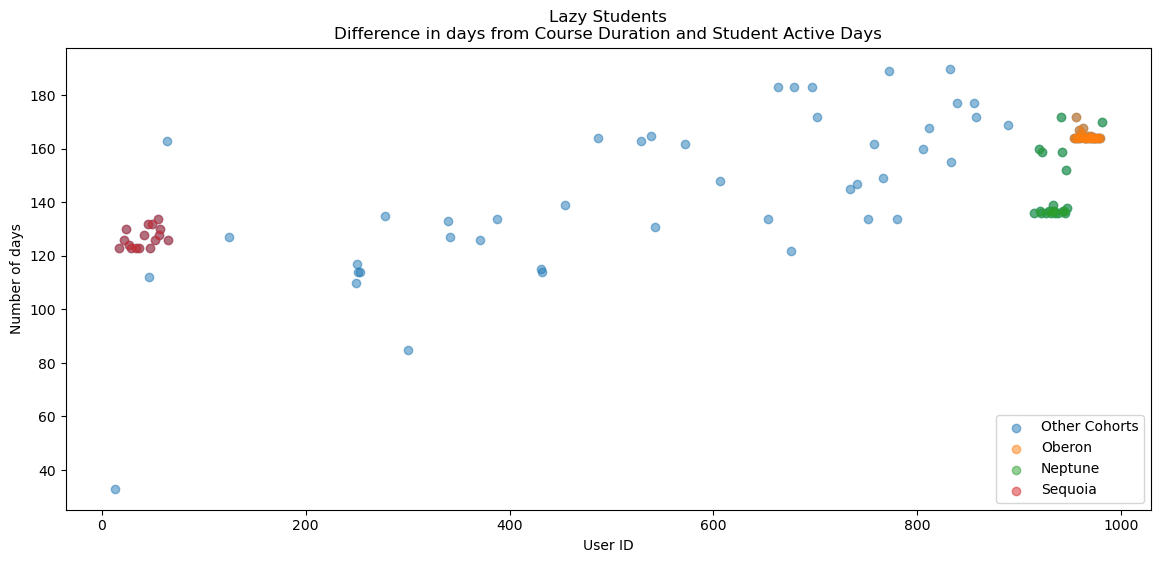

In [24]:
# set plot sizes
fig, ax = plt.subplots(figsize=(14,6))
# set course duration plot
ax.scatter(lazy_users.user_id, lazy_users.duration-lazy_users.days_active, label='Other Cohorts', alpha=.5)
# top cohorts with lazy students
ax.scatter(lazy_users[lazy_users.name=='Oberon'].user_id, lazy_users[lazy_users.name=='Oberon'].duration-lazy_users[lazy_users.name=='Oberon'].days_active, label='Oberon', alpha=.5)
ax.scatter(lazy_users[lazy_users.name=='Neptune'].user_id, lazy_users[lazy_users.name=='Neptune'].duration-lazy_users[lazy_users.name=='Neptune'].days_active, label='Neptune', alpha=.5)
ax.scatter(lazy_users[lazy_users.name=='Sequoia'].user_id, lazy_users[lazy_users.name=='Sequoia'].duration-lazy_users[lazy_users.name=='Sequoia'].days_active, label='Sequoia', alpha=.5)
# set active days plots
# ax.plot(lazy_users.user_id, lazy_users.days_active, label = 'Active Days')
# set legend loc and ylabel
ax.legend(loc='lower right')
ax.set_ylabel('Number of days')
ax.set_xlabel('User ID')
plt.title('Less Active Students\nDifference in days from Course Duration and Student Active Days')
# plot it
plt.show()

In [25]:
# Started by looking at students who accessed the curriculum 
# less often than the duration of their course.
# These students were mostly from program 2 (web dev) and 
# were more likely to have been from cohorts Oberon, Neptune, and Sequoia.
# Most of these students also had a big difference from their active days
# accessing the curriculum and their course duration. There is a possibility
# that some of these students were released from the program.

5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [26]:
df2

,datetime,path,user_id,cohort_id,ip,name,start_date,end_date,program_id,active
0,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,True
4,2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,True
...,...,...,...,...,...,...,...,...,...,...
812088,2021-04-21 16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0,False
812089,2021-04-21 16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0,False
812090,2021-04-21 16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2.0,False
812091,2021-04-21 16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86,Staff,2014-02-04,2014-02-04,2.0,False


In [27]:
# Filter rows based on column: 'name'
cutoff = df2[df2['name'] != "Staff"]

# Filter rows based on column: 'name'
cutoff = cutoff[cutoff['name'] != "unknown"]
cutoff

,datetime,path,user_id,cohort_id,ip,name,start_date,end_date,program_id,active
0,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,True
4,2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,True
...,...,...,...,...,...,...,...,...,...,...
812080,2021-04-21 16:36:09,jquery/personal-site,869,135.0,136.50.98.51,Marco,2021-01-25,2021-07-19,2.0,True
812081,2021-04-21 16:36:34,html-css/css-ii/bootstrap-grid-system,948,138.0,104.48.214.211,Neptune,2021-03-15,2021-09-03,2.0,True
812082,2021-04-21 16:37:48,java-iii,834,134.0,67.11.50.23,Luna,2020-12-07,2021-06-08,2.0,True
812083,2021-04-21 16:38:14,java-iii/servlets,834,134.0,67.11.50.23,Luna,2020-12-07,2021-06-08,2.0,True


In [28]:
wd = cutoff[cutoff.program_id!=3]
wd

,datetime,path,user_id,cohort_id,ip,name,start_date,end_date,program_id,active
0,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,False
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,True
4,2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,True
...,...,...,...,...,...,...,...,...,...,...
812080,2021-04-21 16:36:09,jquery/personal-site,869,135.0,136.50.98.51,Marco,2021-01-25,2021-07-19,2.0,True
812081,2021-04-21 16:36:34,html-css/css-ii/bootstrap-grid-system,948,138.0,104.48.214.211,Neptune,2021-03-15,2021-09-03,2.0,True
812082,2021-04-21 16:37:48,java-iii,834,134.0,67.11.50.23,Luna,2020-12-07,2021-06-08,2.0,True
812083,2021-04-21 16:38:14,java-iii/servlets,834,134.0,67.11.50.23,Luna,2020-12-07,2021-06-08,2.0,True


In [29]:
wd[wd['path'].str.contains("data-science", na=False, case=False)].tail(10)
# wd[wd['path'].str.contains("python", na=False, case=False)]
# wd[wd['path'].str.contains("regression", na=False, case=False)]
# wd[wd['path'].str.contains("classification", na=False, case=False)]

,datetime,path,user_id,cohort_id,ip,name,start_date,end_date,program_id,active
391251,2020-01-13 15:18:58,1-fundamentals/1.1-intro-to-data-science,410,32.0,172.58.107.0,Betelgeuse,2019-05-28,2019-10-08,2.0,False
391254,2020-01-13 15:19:08,1-fundamentals/1.2-data-science-pipeline,410,32.0,172.58.107.0,Betelgeuse,2019-05-28,2019-10-08,2.0,False
656185,2020-11-10 10:14:09,fundamentals/intro-to-data-science,20,22.0,104.190.242.242,Teddy,2018-01-08,2018-05-17,2.0,False
662507,2020-11-17 08:40:22,fundamentals/intro-to-data-science,495,51.0,72.191.58.18,Deimos,2019-09-16,2020-02-27,2.0,False
682483,2020-12-08 15:28:58,fundamentals/intro-to-data-science,143,16.0,68.201.242.151,Niagara,2016-10-26,2017-03-09,2.0,False
686633,2020-12-11 16:06:49,fundamentals/intro-to-data-science,20,22.0,104.190.242.242,Teddy,2018-01-08,2018-05-17,2.0,False
686636,2020-12-11 16:06:59,fundamentals/intro-to-data-science,20,22.0,104.190.242.242,Teddy,2018-01-08,2018-05-17,2.0,False
705577,2021-01-11 09:42:53,fundamentals/intro-to-data-science,20,22.0,104.190.242.242,Teddy,2018-01-08,2018-05-17,2.0,False
745932,2021-02-23 22:01:51,fundamentals/intro-to-data-science,20,22.0,104.190.242.242,Teddy,2018-01-08,2018-05-17,2.0,False
746971,2021-02-25 09:02:46,fundamentals/intro-to-data-science,20,22.0,104.190.242.242,Teddy,2018-01-08,2018-05-17,2.0,False


In [30]:
ds = cutoff[cutoff.program_id==3]
ds

,datetime,path,user_id,cohort_id,ip,name,start_date,end_date,program_id,active
298415,2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,True
298416,2019-08-20 09:40:30,2-storytelling/bad-charts,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,True
298417,2019-08-20 09:40:30,2-storytelling/misleading1_baseball.jpg,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,True
298418,2019-08-20 09:40:30,2-storytelling/misleading1_fox.jpg,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,True
298419,2019-08-20 09:40:30,2-storytelling/misleading3_deaths.jpg,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,True
...,...,...,...,...,...,...,...,...,...,...
812025,2021-04-21 16:01:24,classification/project,841,133.0,99.162.244.233,Easley,2020-12-07,2021-06-08,3.0,True
812054,2021-04-21 16:14:16,regression/project,841,133.0,99.162.244.233,Easley,2020-12-07,2021-06-08,3.0,True
812055,2021-04-21 16:15:51,regression/project,841,133.0,99.162.244.233,Easley,2020-12-07,2021-06-08,3.0,True
812061,2021-04-21 16:23:57,clustering/project,841,133.0,99.162.244.233,Easley,2020-12-07,2021-06-08,3.0,True


In [31]:
ds[ds['path'].str.contains("java", na=False, case=False)].tail(5)
# ds[ds['path'].str.contains("spring", na=False, case=False)]
# ds[ds['path'].str.contains("jquery", na=False, case=False)]
# ds[ds['path'].str.contains("css", na=False, case=False)]

,datetime,path,user_id,cohort_id,ip,name,start_date,end_date,program_id,active
372164,2019-12-03 11:49:29,javascript-i,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,True
372167,2019-12-03 11:49:33,javascript-ii,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,True
372168,2019-12-03 11:49:35,java-ii,467,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,True
378875,2019-12-14 16:46:24,javascript-i,476,34.0,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,True
497763,2020-05-19 16:03:32,java-ii/object-oriented-programming,590,55.0,130.45.47.56,Curie,2020-02-03,2020-07-07,3.0,True


In [32]:
# Yes there is evidence that after 2019 most students were no 
# longer accessing another program's curriculum. There were some 
# students, mostly web dev, that were at least trying to access
# curriculum of the other program, we are unsure on how 
# successful they were.

## function testing

In [45]:
df = df_backup
# Replace missing values with 0 in column: 'program_id'
df = df.fillna({'program_id': 0})
# Filter rows based on column: 'path'
df = df[df['path'] != "/"]
# Filter rows based on column: 'path'
df = df[df['path'] != "toc"]
# Filter rows based on column: 'path'
df = df[df['path'] != "search/search_index.json"]
# Filter rows based on column: 'path'
df = df[df['path'] != "appendix"]
# Filter rows based on column: 'name'
df = df[df['name'] != "Staff"]
# Filter rows based on column: 'name'
df = df[df['name'] != "unknown"]
df2 = df.reset_index()
df2

,datetime,path,user_id,cohort_id,ip,name,start_date,end_date,program_id
0,2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
4,2018-01-26 09:56:41,javascript-i/loops,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0
...,...,...,...,...,...,...,...,...,...
684139,2021-04-21 16:36:09,jquery/personal-site,869,135.0,136.50.98.51,Marco,2021-01-25,2021-07-19,2.0
684140,2021-04-21 16:36:34,html-css/css-ii/bootstrap-grid-system,948,138.0,104.48.214.211,Neptune,2021-03-15,2021-09-03,2.0
684141,2021-04-21 16:37:48,java-iii,834,134.0,67.11.50.23,Luna,2020-12-07,2021-06-08,2.0
684142,2021-04-21 16:38:14,java-iii/servlets,834,134.0,67.11.50.23,Luna,2020-12-07,2021-06-08,2.0


In [46]:
# Performed 1 aggregation grouped on columns: 'program_id', 'path'
pg_path = df2.groupby(['program_id', 'path']).agg(path_count=('path', 'count')).reset_index()
# Sort by column: 'path_count' (descending)
pg_path = pg_path.sort_values(['path_count'], ascending=[False])
pg_path

,program_id,path,path_count
1534,2.0,javascript-i,15640
1508,2.0,java-iii,11290
1428,2.0,html-css,11285
1496,2.0,java-ii,10459
1750,2.0,spring,9973
...,...,...,...
1047,2.0,asset-manifest.json,1
1044,2.0,arash-arghavan,1
1043,2.0,appendix/vocabulary,1
1042,2.0,appendix/useful_libraries,1


In [59]:
# make web dev df
wd = pg_path[pg_path.program_id!=3]
# print(f'path: {wd.path.head(10).tail(1)}')
# print(f'count: {wd.path_count.head(10).tail(1)}')
wdt = wd.head(10).tail(1)
print(wd.head(10).tail(1).path.values[0])

javascript-i/introduction/working-with-data-types-operators-and-variables


In [ ]:
# make data science df
ds = pg_path[pg_path.program_id==3]
# ds[['path','path_count']].head(1)
